## Makemore: becoming a backprop ninja

In [64]:
# there no change change in the first several cells from last lecture

In [65]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [66]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-12-24 20:26:13--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-12-24 20:26:13 (8.42 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [67]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [68]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [69]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
# ok biolerplate done, now we get to the action:

In [71]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [72]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [73]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [74]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3512, grad_fn=<NegBackward0>)

## Calculating Our Backward Pass
We're going to go through each step in calculating the loss, one by one, backwards. This will be our process of manually performing a backword pass through our neural network.

### `dlogprobs`



Let's start with getting the derivative of `logprobs` with respect to `loss`. This is done in the line:

```python
loss = -logprobs[range(n), Yb].mean()
```

First, remember the chain rule, which says:

$\frac{d}{dx}f(g(x)) = f'(g(x)) * g'(x)$

In [75]:
# Here's the values used to calculate loss (or the operations on logprobs)
Yb, logprobs[range(n), Yb]

(tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
         26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18]),
 tensor([-4.0162, -3.0867, -3.5782, -3.2973, -4.1477, -3.4795, -3.3522, -4.0521,
         -3.1649, -4.2128, -3.1414, -1.6849, -2.8205, -2.8727, -3.0433, -3.1802,
         -3.7319, -2.9491, -3.5728, -3.4428, -2.8714, -2.9693, -4.2792, -3.9525,
         -3.5632, -2.9193, -3.1328, -3.9430, -2.7124, -3.6829, -3.2276, -3.1591],
        grad_fn=<IndexBackward0>))

Here it's useful to think about calculating loss in an example. Let's say we're summing across 3 rows:

$loss = \frac{-1}{3}(a + b + c)$

The partial derivative, $\frac{dloss}{da}$, is $\frac{-1}{3}$. In our larger case, it's $\frac{1}{27}$ because we're getting the mean of 27 items (next letter predictions).

However, we're not using all 27 items in our loss, so the rest of the items have a gradient of 0. In order to achieve this, we create a matrix with full zeros in the same size as logprops and only set the gradient for those 27 letter predictions which we use in the loss calculation.

In [76]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### `dprobs`



The use of probs in our forward function goes as follows:

```python
logprobs = probs.log()
```

What is the derivative of the log function?

$\frac{d}{dx}log_a(x) = \frac{1}{xln(a)}$

With the `.log()` function, $a = e$, meaning the derivative is just $\frac{1}{x}$. So our caculation of probs should be fairly straight forward, **but don't forget the chain rule**. We must multiple by the derivative of logprobs as well.

In [77]:
dprobs = dlogprobs * (1.0 / probs)
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


### `dcounts` & `dcounts_sum_inv`

**Code:**
```python
probs = counts * counts_sum_inv
```

`counts` and `counts_sum_inv`, at first glance, are pretty intuitive calculation, but there's a catch. While we can calculate `counts_sum_inv` with only the chain rule, `counts` is used else where in the code. As in micrograd, we'll sum the gradients to find `dcounts`, but until then, we don't have a final value for `dcounts`.

For finding `dcounts_sum_inv`, we must look at the shapes involved in our operations.

In [78]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

There is some broadcasting going on with our element-wise multiplication between `counts` and `counts_sum_inv`. This broadcasting is happening along the second dimension, is a single column, duplicated to fill 27 columns for each row.

In doing our manual back propagation, we need to sum along this dimension.

In [79]:
dcounts = dprobs * counts_sum_inv # Not final
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim = True)
dcounts_sum_inv = dcounts_sum_inv.sum(1, keepdim = True)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0


### `dcounts_sum`

**Code:**
```python
counts_sum_inv = counts_sum**-1
```

This should be an easy use of the chain rule, but we also need to know the derivative of $\frac{1}{x}$, which is: $\frac{-1}{x^2}$.

To be sure from now on of broadcasting errors, let's print the shapes of our tensors.

In [80]:
counts_sum.shape

torch.Size([32, 1])

In [81]:
dcounts_sum = dcounts_sum_inv * -(counts_sum**-2)
cmp('dcounts_sum', dcounts_sum, counts_sum)

dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0


### `dcounts`

`dcounts` has already been partially calculated since it was used with `dcounts_sum_inv`. Now, we'll complete this calculation of `dcounts` and add onto the previous result.

**Code:**
```python
counts_sum = counts.sum(1, keepdim = True)
```

In this case, we're summing across the second dimension. Two steps ago, in reflection of some broadcasting across a certain, we summed across that dimension to get the derivative. In the same mindset, when we sum across the second dimension, we're going to broadcast `dcounts_sum` into the dimensions of `counts`.

In [82]:
counts.shape, counts_sum.shape, dcounts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 1]))

In [83]:
dcounts += dcounts_sum.broadcast_to((32, 27))
cmp('dcounts', dcounts, counts)

dcounts         | exact: True  | approximate: True  | maxdiff: 0.0


### `dnorm_logits`

For `dnorm_logits`, the calculation should be fairly simple. First, we need the derivative of $e^x$, which is fortunately $e^x$. This means that `norm_logits.exp()` is our local derivative and all we have to do is multiply by our outer derivative, `dcounts`.

**Code:**
```python
counts = norm_logits.exp()
```

In [84]:
counts.shape, norm_logits.shape, dcounts.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 27]))

In [85]:
dnorm_logits = dcounts * norm_logits.exp()
cmp('dnorm_logits', dnorm_logits, norm_logits)

dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0


### `dlogits` & `dlogit_maxes`

**Code:**
```python
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
```

Let's start doing bigger pieces. We need the derivative of `logits` and `logit_maxes`, which are used in these two lines. Let's start with `logit_maxes` since it is only used in calculating `norm_logits`.

We know from micrograd that when there is an addition (or subtraction), the outer derivative pushed onto the local derivatives. So, `dlogit_maxes` is just the negation of `dnorm_logits`.

In [86]:
dnorm_logits.shape, logits.shape, logit_maxes.shape # Some broadcasting on logit_maxes

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

So turns out there's some broadcasting being done on `logit_maxes`, specifically on replicating single column into 27 columns for each row. In order to reverse this, we need to do the steps as previously mentioned to get the `dlogit_maxes`, but the sum across that second dimension.

In [87]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim = True)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0


Now onto `dlogits`. When we first calculated `dlogprobs`, we indexed the array for only predictions of the actual next character. This indexing meant that the gradients for predictions of characters which were not used were set to 0. Something very similar should be done in calculating `dlogits`. Finding the max of each row means all the other values which aren't the max end with a gradient of 0.

Our job is to now set the gradient for all of the items to be 0, then fill in the values of our maxes in their respected positions.

In [88]:
logit_maxes

tensor([[1.1046],
        [0.9205],
        [1.1279],
        [0.7170],
        [1.7313],
        [0.8735],
        [0.8433],
        [1.3931],
        [1.0201],
        [1.0004],
        [1.7624],
        [2.0121],
        [1.0004],
        [0.7677],
        [0.4990],
        [0.8161],
        [0.9938],
        [0.8280],
        [1.0004],
        [0.8308],
        [0.8102],
        [1.0501],
        [1.0004],
        [1.1752],
        [1.5557],
        [1.0327],
        [1.1393],
        [0.8972],
        [1.0149],
        [0.7909],
        [1.1229],
        [0.9439]], grad_fn=<MaxBackward0>)

In [89]:
# dlogits = dnorm_logits.clone()
# max_values = torch.zeros_like(logits)

# row_i = 0
# max_index_pair = zip(logits.max(dim = 1)[0], logits.max(dim = 1)[1])
# for value, index in max_index_pair:
#   max_values[row_i][index] = value
#   row_i += 1

# dlogits += max_values * dlogit_maxes
# cmp('dlogits [MINE]', dlogits, logits)

# Karpathy's code:
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices,
                     num_classes = logits.shape[1]) * dlogit_maxes
cmp('dlogits [KARP]', dlogits, logits)

dlogits [KARP]  | exact: True  | approximate: True  | maxdiff: 0.0


### `dH`, `dW`, & `db`

To calculate the partial derivatives of `H`, `W`, and `b`, we need to know how to do the derivative of matrix multiplications. If we multiply the outer derivative by the transpose of the multiplication which multiples, for example `h`, we can find `dh`.

**Code:**
```python
logits = h @ W2 + b2 # output layer
```

In [90]:
print(f"dlogits: {dlogits.shape}")
print(f"h: {h.shape}")
print(f"W2: {W2.shape}")
print(f"b2: {b2.shape}")

dlogits: torch.Size([32, 27])
h: torch.Size([32, 64])
W2: torch.Size([64, 27])
b2: torch.Size([27])


How do we know which matrices to multiply and which matrices to transpose? Our `dh` needs to have the same shape as `h`. `h.shape` is (32, 64), so we need to multiply to matrices that result in a matrix what is also (32, 64). In this case, it's `dlogits` and `W2.T`.

In [91]:
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
cmp('dh', dh, h)
cmp('dW2', dW2, W2)

dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0


Now for calculating `db2`, we need to pay attention to the dimensions of `b2`. There's some broadcasting going on, but in the 0th dimension. So, in order to get back to these dimensions, we need to sum across the first dimension of `dlogits`. We don't need `keepdim` to be True, since we want (27), not (1, 27).

In [92]:
db2 = dlogits.sum(0)
cmp('db2', db2, b2)

db2             | exact: True  | approximate: True  | maxdiff: 0.0


### `dhpreact`

For `dhpreact`, we need to know the derivative of tanh and use the product rule. We can look up the derivative, which is: $1 - tanh^2(x)$. Also, we don't need to calculate of $tanh(preact)$, since that already equals to h.

**Code:**
```python
h = torch.tanh(hpreact)
```

In [93]:
h.shape, dh.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [94]:
dhpreact = (1.0 - h**2) * dh
cmp('dhpreact', dh, h)

dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0


### `bngain`, `bnraw`, & `bnbias`

**Code:**
```python
hpreact = bngain * bnraw + bnbias
```

In [95]:
print(f"dhpreact: {dhpreact.shape}")
print(f"bngain: {bngain.shape}")
print(f"bnraw: {bnraw.shape}")
print(f"bnbias: {bnbias.shape}")

dhpreact: torch.Size([32, 64])
bngain: torch.Size([1, 64])
bnraw: torch.Size([32, 64])
bnbias: torch.Size([1, 64])


In [96]:
dbngain = (bnraw * dhpreact).sum(0, keepdim = True)
dbnraw = bngain.broadcast_to((32, 64)) * dhpreact
dbnbias = dhpreact.sum(0, keepdim = True)

cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)

dbngain         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
dbnraw          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
dbnbias         | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


### `dbnvar_inv` & `dbndiff`

**Code:**
```python
bnraw = bndiff * bnvar_inv
```

Calculating `dbnvar_inv` is fairely intuitive, since we have the outside derivative and can apply the chain rule. However, calculating `dbndiff`requires the gradients from the other operations, so we must finish the rest of the steps.

In [97]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

There's some implict broadcasting, so we'll have to sum across the first dimension.

In [98]:
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
dbndiff =(dbnraw * bnvar_inv)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar_inv      | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


Let's come back to `dbndiff` as we go through each other line.

### `dbnvar`



**Code:**
```python
bnvar_inv = (bnvar + 1e-5)**-0.5
```

Let's map out the equation more clearly with latex:

$y=\frac{1}{\sqrt{x+ 10^{-5}}}$

We can use the exponent rule to get the derivative.

In [99]:
bnvar_inv.shape, bnvar.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [100]:
dbnvar = dbnvar_inv * (-0.5 * (bnvar + 1e-5)**-1.5)
cmp('dbnvar', dbnvar, bnvar)

dbnvar          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


### `dbndiff2` & `dbndiff`

**Code:**
```python
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bndiff2 = bndiff**2
```

In latex:
$\frac{1}{n-1}*{x_{summed}}$

In [101]:
bnvar.shape, bndiff2.shape, dbnvar.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [110]:
dbndiff2 = 1.0 / (n-1.0) * dbnvar.broadcast_to((32, 64))
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff2        | exact: False | approximate: True  | maxdiff: 2.1827872842550278e-11


Now onto `dbndiff`. Remember, we calculated the first part of dbndiff two examples ago, so we'll have to sum this next calculation onto the existing dbndiff. For reference, it was calculated as follows:

```python
dbndiff =(dbnraw * bnvar_inv)
```

In [111]:
dbndiff = (dbnraw * dbnvar_inv)
dbndiff += (2 * bndiff) * dbndiff2
cmp('dbndiff', dbndiff, bndiff)

dbndiff         | exact: False | approximate: False | maxdiff: 0.007316019851714373


### `dhprebn` & `bnmeani`

**Code:**
```python
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
```

In [104]:
bndiff.shape, hprebn.shape, bnmeani.shape # Some broadcasting on bnmeani

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [105]:
dbnmeani = -dbndiff.sum(0, keepdim = True)
cmp('dbnmeani', dbnmeani, bnmeani)

dhprebn = dbndiff
dhprebn += 1/n * dbnmeani.broadcast_to((32, 64))
cmp('dhprebn', dhprebn, hprebn)

dbnmeani        | exact: False | approximate: False | maxdiff: 0.03485224395990372
dhprebn         | exact: False | approximate: False | maxdiff: 0.00754727004095912


### `dembcat`, `W1`, & `b1`

**Code:**
```python
hprebn = embcat @ W1 + b1
```

In [106]:
embcat.shape, W1.shape, b1.shape, dhprebn.shape # Some broadcasting on b1

(torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [107]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)

dembcat         | exact: False | approximate: False | maxdiff: 0.012269515544176102
dW1             | exact: False | approximate: False | maxdiff: 0.03635820001363754
db1             | exact: False | approximate: True  | maxdiff: 2.2992026060819626e-09


### `demb` & `dC`

**Code**:
```python
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
```

In [108]:
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k, j]
    dC[ix] += demb[k, j]

cmp('emb', demb, emb)
cmp('C', dC, C)

emb             | exact: False | approximate: False | maxdiff: 0.012269515544176102
C               | exact: False | approximate: False | maxdiff: 0.04075043275952339


## Testing Our Backward Pass

In [109]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw           | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnvar_inv       | exact: False | approximate: True  | max

## Excercise 2

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3346469402313232 diff: 0.0


With calculating the partial derivative of the cross entropy function with respect to the loss, we do all the math and it eventually canceles to $P_i$ or $P_i - 1$, where $P$ is the prediction vector.

In [112]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


In [119]:
F.softmax(logits, 1)[0]

tensor([0.0737, 0.0957, 0.0215, 0.0454, 0.0201, 0.0780, 0.0227, 0.0323, 0.0180,
        0.0291, 0.0357, 0.0356, 0.0347, 0.0294, 0.0364, 0.0152, 0.0099, 0.0190,
        0.0160, 0.0513, 0.0489, 0.0226, 0.0233, 0.0762, 0.0609, 0.0261, 0.0225],
       grad_fn=<SelectBackward0>)

In [113]:
dlogits[0] * n

tensor([ 0.0737,  0.0957,  0.0215,  0.0454,  0.0201,  0.0780,  0.0227,  0.0323,
        -0.9820,  0.0291,  0.0357,  0.0356,  0.0347,  0.0294,  0.0364,  0.0152,
         0.0099,  0.0190,  0.0160,  0.0513,  0.0489,  0.0226,  0.0233,  0.0762,
         0.0609,  0.0261,  0.0225], grad_fn=<MulBackward0>)

In [116]:
dlogits[0].sum()

tensor(-2.5611e-09, grad_fn=<SumBackward0>)

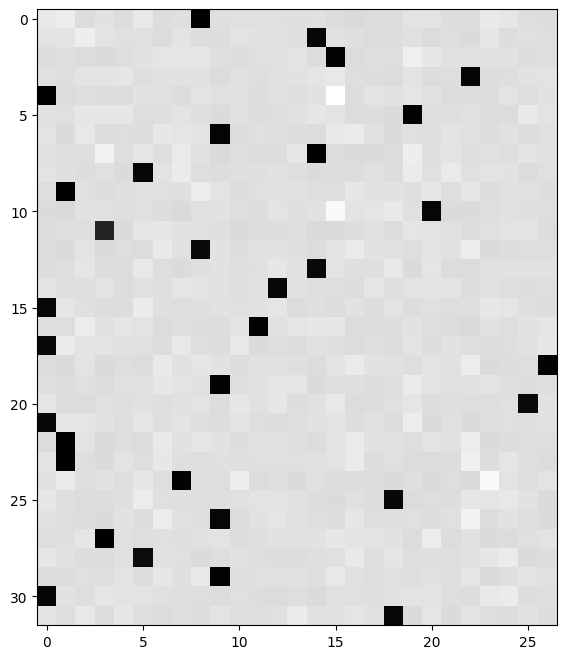

In [115]:
plt.figure(figsize =(8, 8))
plt.imshow(dlogits.detach(), cmap = 'gray')

Here with `dlogits`, we're measuring how much we need to sway the whole neural network based on it's output. In this specific example, the black squares are the predictions for the correct next character after a subtraction of one. If the model is completely accurate, than it would be 1 minus 1. The rest of the predictions would also be 0 in this case.

Why is this important? It shows us how gradient descent is trying to move the weights of the model. "The amount of which you mis-predict, is the amount of the strength of the pull".

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [120]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))